In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
%cd ~\OneDrive\Documents\thebrand

C:\Users\igari\OneDrive\Documents\thebrand


# Project objective: Demand forecast (unit sales) for potential new products for "The Brand"

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from src.utils.constants import TARGET, MODEL_FEATURES
from src.utils.funcs import get_nrf_color_group

import warnings
warnings.filterwarnings("ignore")

In [4]:
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", 99)
pd.set_option("display.max_colwidth", 199)

In [5]:
base_dir = Path("/Users/igari/OneDrive/Documents/thebrand")
data = base_dir / "data"

# A note on choice of models

Model requirements:
   - Should be able to detect interactions without coding for interaction features
   - Should be able to handle new values of categorical features
   - Should generalise well and be less prone to overfitting

Decision trees are generally better at uncovering feature interactions without explicitly coding for them. Therefore, in interest of time, we will skip testing linear regression models but ideally, this should be done.

# Read in training data

In [6]:
train_path = data / "01_raw" / "train_raw.csv"
train = pd.read_parquet(train_path)

y_train = train.loc[:, [TARGET]]
X_train = train.loc[:, MODEL_FEATURES]

X_train.head()

,MATERIAL_CONTENT_CODE,PRODUCT_TYPES,BUSINESS_SEGMENTS,Sustainablity,MARKETING_CATEGORY,nrf_color_group
0,75.83,76.79,77.01,1,76.50,1
1,74.53,72.17,74.08,1,76.33,1
2,74.53,75.37,74.50,2,76.56,2
3,74.57,74.88,75.86,3,95.39,3
4,64.82,66.97,73.71,4,49.92,1


# Test data preprocessing

In [7]:
test_path = data / "01_raw" / "test_raw.csv"
test = pd.read_parquet(test_path)
test.shape

(12128, 7)

In [8]:
# Outlier removal at 216.0
test = test[test.Units_sold < 216]

# Feature nrf color group
test["nrf_color_group"] = test.apply(get_nrf_color_group, axis=1)

# Categorical encoding
oe_encoder_path = base_dir / "artifacts" / "oe_encoder.pkl"
file = open(oe_encoder_path, "rb")
oe_encoder = pickle.load(file)
test = oe_encoder.fit_transform(test)

encoder_path = base_dir / "artifacts" / "encoder.pkl"
file2 = open(encoder_path, "rb")
encoder = pickle.load(file2)
test = encoder.transform(test)
test.head()

,MATERIAL_CONTENT_CODE,PRODUCT_TYPES,BUSINESS_SEGMENTS,NRF_COLOR_CODE,Sustainablity,MARKETING_CATEGORY,Units_sold,nrf_color_group
7,74.23,74.37,74.55,1.00,1,99.51,36,1
8,73.66,74.83,74.68,610.00,9,70.91,120,12
9,74.53,73.47,72.68,610.00,2,100.52,120,12
10,62.85,74.37,74.55,307.00,10,50.93,96,11
11,77.33,75.54,73.71,1.00,9,70.91,108,1


In [9]:
y_test = test.loc[:, [TARGET]]
X_test = test.loc[:, MODEL_FEATURES]

X_train.to_parquet(data / "02_intermediate/X_train.csv", index=None)
X_test.to_parquet(data / "02_intermediate/X_valid.csv", index=None)
y_train.to_parquet(data / "02_intermediate/y_train.csv", index=None)
y_test.to_parquet(data / "02_intermediate/y_valid.csv", index=None)

We will use evaluation metric: MAE

### Comparing various algorithms

Let us see whether bagging does better or boosting in this problem

#### Random Forest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   53.8s


Training MAE: 30.67936997096641
Test MAE: 35.17684097124389


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


<AxesSubplot:>

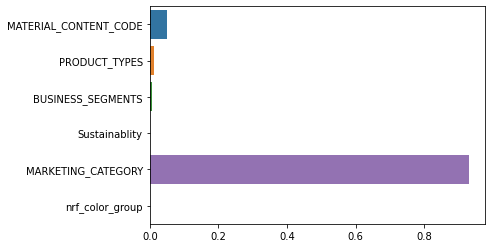

In [10]:
est_rf = RandomForestRegressor(
    criterion="absolute_error", max_depth=5, verbose=1, n_jobs=-1
)

est_rf.fit(
    X_train.loc[:, MODEL_FEATURES],
    np.array(y_train).reshape(
        -1,
    ),
)

rf_pred_train = est_rf.predict(X_train[MODEL_FEATURES])
rf_pred_test = est_rf.predict(X_test[MODEL_FEATURES])

print(f"Training MAE: {mean_absolute_error(y_train, rf_pred_train)}")
print(f"Test MAE: {mean_absolute_error(y_test, rf_pred_test)}")

sns.barplot(x=est_rf.feature_importances_, y=MODEL_FEATURES)

      Iter       Train Loss   Remaining Time 
         1        1476.6466            3.49s
         2        1452.0053            3.55s
         3        1431.6570            3.56s
         4        1415.0081            4.01s
         5        1401.4865            3.96s
         6        1390.2132            3.97s
         7        1380.8787            3.79s
         8        1373.2495            3.87s
         9        1366.7314            3.84s
        10        1361.4476            3.78s
        20        1336.5210            3.27s
        30        1328.0557            2.82s
        40        1323.1804            2.42s
        50        1319.7823            2.02s
        60        1316.7200            1.63s
        70        1312.9982            1.21s
        80        1310.8781            0.80s
        90        1307.8181            0.40s
       100        1304.1535            0.00s
Training MAE: 30.333248187606173
Test MAE: 34.58144729714273
Training MAPE: 0.8120859606024257
Test

<AxesSubplot:>

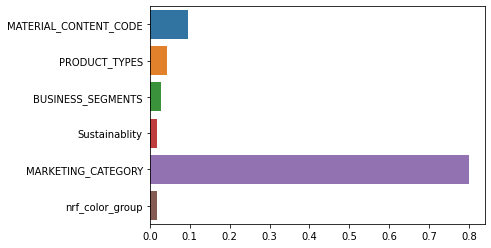

In [30]:
est_gb = GradientBoostingRegressor(max_depth=5, loss="squared_error", verbose=1)

est_gb.fit(
    X_train.loc[:, MODEL_FEATURES],
    np.array(y_train).reshape(
        -1,
    ),
)

gb_pred_train = est_gb.predict(X_train[MODEL_FEATURES])
gb_pred_test = est_gb.predict(X_test[MODEL_FEATURES])

print(f"Training MAE: {mean_absolute_error(y_train, gb_pred_train)}")
print(f"Test MAE: {mean_absolute_error(y_test, gb_pred_test)}")

print(f"Training MAPE: {mean_absolute_percentage_error(y_train, gb_pred_train)}")
print(f"Test MAPE: {mean_absolute_percentage_error(y_test, gb_pred_test)}")

sns.barplot(x=est_gb.feature_importances_, y=MODEL_FEATURES)

Both are giving comparable results so let us stick to boosting for now as it ran faster than bagging.

There is a huge scope to fix the categorical encoder here as all the weight is going to `MARKETING_CATEGORY` here which is not ideal.

## How do training vs test MAE change with max depth?

In [ ]:
training_mae = []
test_mae = []
for d in range(2, 20):
    est_rf = GradientBoostingRegressor(max_depth=d, loss="squared_error")

    est_rf.fit(
        X_train.loc[:, MODEL_FEATURES],
        np.array(y_train).reshape(
            -1,
        ),
    )

    rf_pred_train = est_rf.predict(X_train[MODEL_FEATURES])
    rf_pred_test = est_rf.predict(X_test[MODEL_FEATURES])

    training_mae.append(mean_absolute_error(y_train, rf_pred_train))
    test_mae.append(mean_absolute_error(y_test, rf_pred_test))

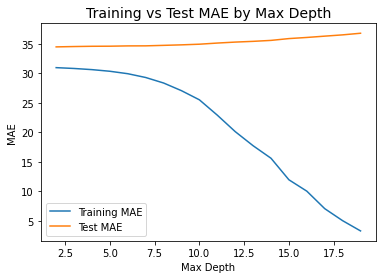

In [40]:
plt.title("Training vs Test MAE by Max Depth", fontdict={"fontsize": 14})
plt.xlabel("Max Depth", fontsize=10)
plt.ylabel("MAE", fontsize=10)

sns.lineplot(range(2, 20), training_mae, label="Training MAE")
sns.lineplot(range(2, 20), test_mae, label="Test MAE")
plt.legend()
plt.show()

The model requires further tuning and more predictors clearly. The MAPE is really bad.
</br> Here are tuning ideas:


# Example data point prediction

In [13]:
# New data point
new = pd.DataFrame(
    {
        "MATERIAL_CONTENT_CODE": ["AT2F"],
        "PRODUCT_TYPES": [1],
        "BUSINESS_SEGMENTS": [30308],
        "NRF_COLOR_CODE": [734],
        "Sustainablity": ["Low carbon footprint"],
        "MARKETING_CATEGORY": ["P219"],
        "Units_sold": [np.nan],
    }
)

In [14]:
# Feature nrf color group
new["nrf_color_group"] = new.apply(get_nrf_color_group, axis=1)

# Categorical encoding
new = oe_encoder.fit_transform(new)
new = encoder.transform(new)

est_rf.predict(new[MODEL_FEATURES])

array([71.96868458])

In [41]:
# Serialize the model
gb_model_path = base_dir / "artifacts" / "gb_model.pkl"
file = open(gb_model_path, "wb")
pickle.dump(est_gb, file)

In [15]:
# TODO: Add requirements.txt, fill the README or delete it